### **Théorie : Équation Fondamentale du Modèle Double Variance (Eq. 56)**

La densité spectrale $\rho(\gamma)$ est déterminée par la méthode des répliques. On cherche la racine physique $q^*$ de l'équation cubique suivante :

$$z q^3 + q^2 \left( \alpha_m - 1 - \frac{z\alpha_m }{\sigma_1^2} - \frac{z\alpha_m }{\sigma_2^2} \right) + q \left( \frac{\alpha_m^2}{\sigma_1^2 \sigma_2^2} (z - f \sigma_1^2 - (1-f) \sigma_2^2) + \frac{\alpha_m }{\sigma_1^2} + \frac{\alpha_m }{\sigma_2^2} \right) - \frac{\alpha_m^2}{\sigma_1^2 \sigma_2^2} = 0$$

Où les coefficients sont définis par les paramètres du modèle $\alpha_m = m/d$, la fraction $f$, et les variances $\sigma_1^2, \sigma_2^2$

La densité spectrale finale $\rho(\gamma)$ est extraite de la partie imaginaire de la racine $q^*$ pour un petit paramètre de régularisation $\epsilon \to 0$ ($z = \gamma - i\epsilon$) :

$$\rho(\gamma) = \frac{\alpha_m}{\pi} \lim_{\epsilon \to 0^+} \text{Im}[q^*]$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def compute_spectrum(gamma_vals, alpha, f, s1, s2, eps=1e-12):
    rho = np.zeros_like(gamma_vals)
    
    for idx, gamma in enumerate(gamma_vals):
        z = gamma - 1j * eps
        
        c3 = z
        c2 = alpha - 1 - z*alpha/s1 - z*alpha/s2
        c1 = (alpha**2 / (s1*s2)) * (z - f*s1 - (1-f)*s2) + alpha/s1 + alpha/s2
        c0 = -alpha**2 / (s1*s2)
        
        roots = np.roots([c3, c2, c1, c0])
        valid_roots = [r for r in roots if r.imag > 1e-15]
        
        if valid_roots:
            q_star = max(valid_roots, key=lambda x: x.imag)
            rho[idx] = (alpha / np.pi) * q_star.imag
    
    return rho/alpha

def compute_rho(gamma, alpha, f, s1, s2, eps=1e-12):
    """Calcule rho pour une seule valeur de gamma"""
    z = gamma - 1j * eps
    
    # coefficients de l'equation 56
    c3 = z
    c2 = alpha - 1 - z*alpha/s1 - z*alpha/s2
    c1 = (alpha**2 / (s1*s2)) * (z - f*s1 - (1-f)*s2) + alpha/s1 + alpha/s2
    c0 = -alpha**2 / (s1*s2)
    
    roots = np.roots([c3, c2, c1, c0])
    valid_roots = [r for r in roots if r.imag > 0]
    
    if valid_roots:
        q_star = max(valid_roots, key=lambda x: x.imag)
        return (alpha / np.pi) * q_star.imag
    return 0.0

def find_gap_bounds(alpha, f, s1, s2, gamma_search_min=0.01, gamma_search_max=5.0, n_points=10000):
    """
    Trouve gamma_minus et gamma_plus numériquement.
    gamma_minus = borne droite du premier bulk (fin du pic)
    gamma_plus = borne gauche du second bulk (début du bulk large)
    """
    gamma_vals = np.linspace(gamma_search_min, gamma_search_max, n_points)
    rho_vals = np.array([compute_rho(g, alpha, f, s1, s2) for g in gamma_vals])
    
    # Trouver le minimum local (position du gap)
    # D'abord trouver le max du premier pic
    peak1_idx = np.argmax(rho_vals[:n_points//4])
    
    # Puis chercher le minimum après ce pic
    search_start = peak1_idx + 100
    search_end = n_points // 2
    min_idx = search_start + np.argmin(rho_vals[search_start:search_end])
    
    gamma_gap = gamma_vals[min_idx]
    rho_min = rho_vals[min_idx]
    
    # Seuil pour définir les bornes (là où rho tombe proche du minimum)
    threshold = rho_min + 0.005
    
    # gamma_minus : dernière position avant le gap où rho > threshold
    left_region = gamma_vals[:min_idx]
    rho_left = rho_vals[:min_idx]
    above_threshold_left = np.where(rho_left > threshold)[0]
    if len(above_threshold_left) > 0:
        gamma_minus = left_region[above_threshold_left[-1]]
    else:
        gamma_minus = gamma_gap
    
    # gamma_plus : première position après le gap où rho > threshold
    right_region = gamma_vals[min_idx:]
    rho_right = rho_vals[min_idx:]
    above_threshold_right = np.where(rho_right > threshold)[0]
    if len(above_threshold_right) > 0:
        gamma_plus = right_region[above_threshold_right[0]]
    else:
        gamma_plus = gamma_gap
    
    return gamma_minus, gamma_plus

def transform_spectrum_to_J(gamma_vals, rho_gamma, t):
    r_vals = -t / (t + gamma_vals + 1e-15)
    
    jacobian = ((t + gamma_vals)**2) / t
    rho_r = rho_gamma * jacobian

    sort_indices = np.argsort(r_vals)
    r_vals = r_vals[sort_indices]
    rho_r = rho_r[sort_indices]
    
    return r_vals, rho_r

def transform_bounds_to_J_approx(gamma_minus, gamma_plus, t):
    r_minus = -t / (t + gamma_minus)
    r_plus = -t / (t + gamma_plus)
    return r_minus, r_plus

gamma_minus = 0.3578
gamma_plus = 0.5639


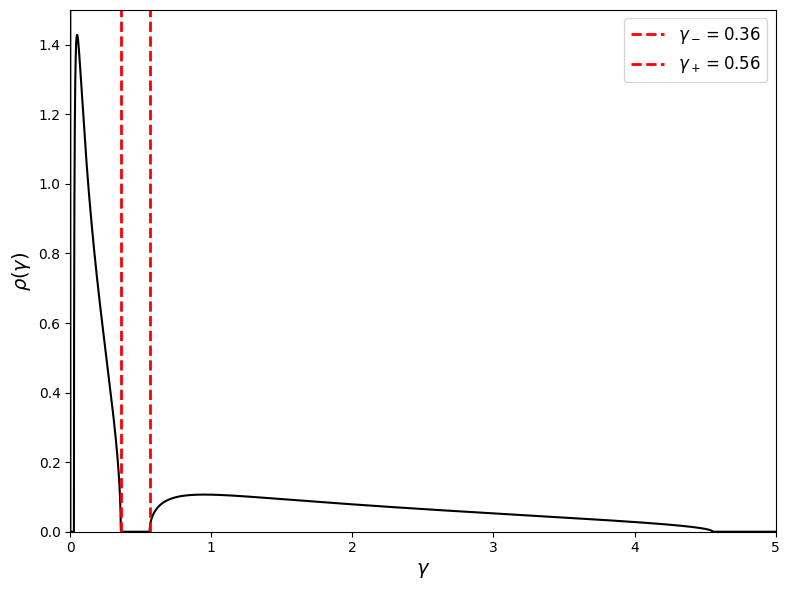

In [3]:
# Test
alpha = 0.5
f = 0.5
s1 = 1.0
s2 = 0.1

gamma_minus, gamma_plus = find_gap_bounds(alpha, f, s1, s2)
print(f"gamma_minus = {gamma_minus:.4f}")
print(f"gamma_plus = {gamma_plus:.4f}")

# Plot
gamma_vals = np.linspace(0, 5, 100000)
rho = compute_spectrum(gamma_vals, alpha, f, s1, s2)

plt.figure(figsize=(8, 6))
plt.plot(gamma_vals, rho, 'k-', linewidth=1.5)
plt.axvline(x=gamma_minus, color='red', linestyle='--', linewidth=2, label=rf'$\gamma_- = {gamma_minus:.2f}$')
plt.axvline(x=gamma_plus, color='red', linestyle='--', linewidth=2, label=rf'$\gamma_+ = {gamma_plus:.2f}$')
plt.xlabel(r'$\gamma$', fontsize=14)
plt.ylabel(r'$\rho(\gamma)$', fontsize=14)
plt.xlim(0, 5)
plt.ylim(0, 1.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

Bornes gamma: [0.0260, 0.3034]
t = 10...
t = 0.1...
t = 0.01...
t = 0.0005...


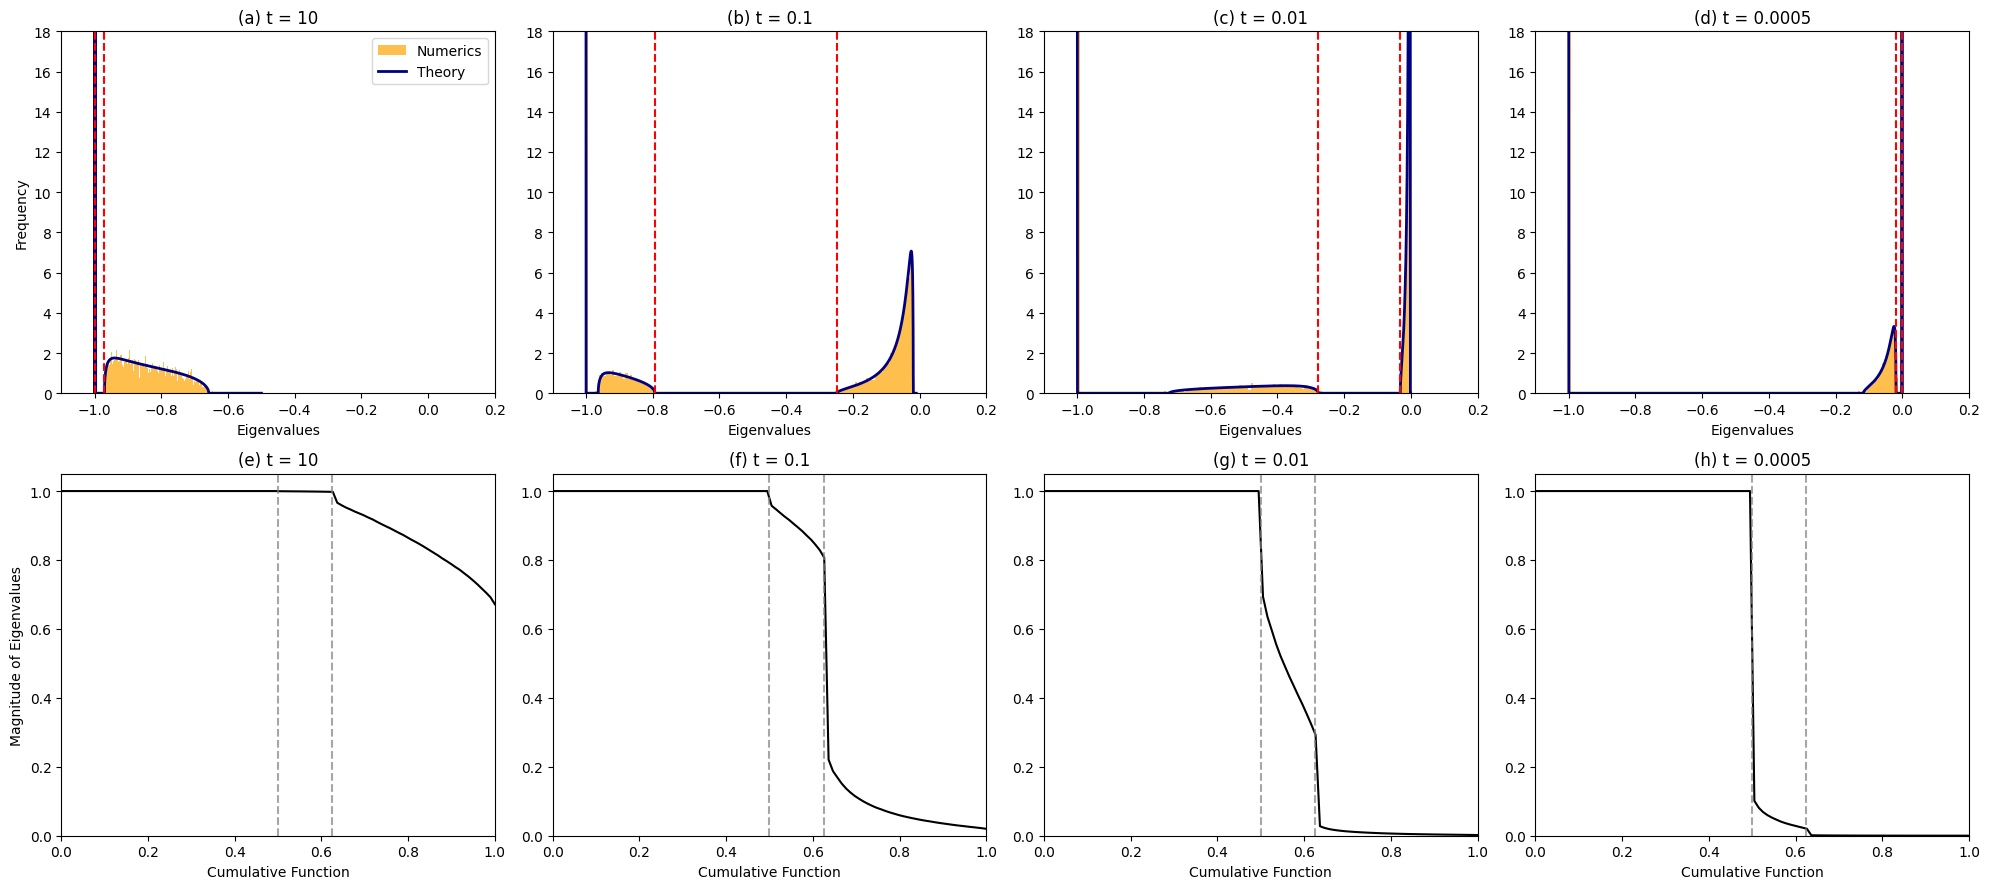

In [4]:
# --- PARAMÈTRES ---
d = 100
alpha = 0.5 
m = int(d * alpha)
s1 = 1.0
s2 = 0.01
f = 0.75
T = [10, 0.1, 0.01, 5e-4]
nb_realisations = 100

# Bornes du gap
g_minus, g_plus = find_gap_bounds(alpha, f, s1, s2)
print(f"Bornes gamma: [{g_minus:.4f}, {g_plus:.4f}]")

# Spectre théorique (calculé une seule fois)
gamma_vals = np.geomspace(1e-12, 10, 10000)
rho_gamma = compute_spectrum(gamma_vals, alpha, f, s1, s2)

# --- FIGURE ---
fig, axes = plt.subplots(2, 4, figsize=(20, 9))

for i, t in enumerate(T):
    print(f"t = {t}...")
    
    # A. SIMULATION NUMÉRIQUE
    all_eigs = []
    m1, m2 = int(m * f), m - int(m * f)
    for _ in range(nb_realisations):
        F1 = np.random.normal(0, np.sqrt(s1/m), (d, m1))
        F2 = np.random.normal(0, np.sqrt(s2/m), (d, m2))
        F = np.hstack([F1, F2])
        FtF = F.T @ F
        J_t = (1/t) * F @ np.linalg.solve(np.eye(m) + (1/t)*FtF, F.T) - np.eye(d)
        all_eigs.append(np.linalg.eigvalsh(J_t))
    
    all_eigs = np.array(all_eigs)
    eigs_num = all_eigs.flatten()

    # B. THÉORIE (utilise les fonctions)
    r_vals, rho_J = transform_spectrum_to_J(gamma_vals, rho_gamma, t)
    r_minus, r_plus = transform_bounds_to_J_approx(g_minus, g_plus, t)

    # C. PLOT HAUT (DENSITÉS)
    ax_top = axes[0, i]
    ax_top.hist(eigs_num, bins=150, density=True, color='orange', alpha=0.7, label='Numerics')
    ax_top.plot(r_vals, rho_J, 'navy', lw=2, label='Theory')
    ax_top.axvline(r_minus, color='red', ls='--', lw=1.5)
    ax_top.axvline(r_plus, color='red', ls='--', lw=1.5)
    ax_top.set_title(f"({chr(97+i)}) t = {t}")
    ax_top.set_xlim(-1.1, 0.2)
    ax_top.set_ylim(0, 18)
    ax_top.set_xlabel("Eigenvalues")
    if i == 0: 
        ax_top.set_ylabel("Frequency")
        ax_top.legend()

    # D. CUMULATIVE
    ax_bot = axes[1, i]
    sorted_per_run = np.sort(np.abs(all_eigs), axis=1)[:, ::-1]
    mean_sorted_mag = np.mean(sorted_per_run, axis=0)
    mean_sorted_mag_normalized = mean_sorted_mag / np.max(mean_sorted_mag)
    cumulative_x = np.linspace(0, 1, d)
    
    ax_bot.plot(cumulative_x, mean_sorted_mag_normalized, 'k-', lw=1.5)
    ax_bot.axvline(x=f * alpha + (1-f)*alpha, color='gray', ls='--', alpha=0.7)
    ax_bot.axvline(x=alpha + (1-f)*alpha, color='gray', ls='--', alpha=0.7)
    ax_bot.set_xlim(0, 1.0)
    ax_bot.set_ylim(0, 1.05)
    ax_bot.set_xlabel("Cumulative Function")
    ax_bot.set_title(f"({chr(101+i)}) t = {t}")
    if i == 0:
        ax_bot.set_ylabel("Magnitude of Eigenvalues")

plt.tight_layout()
plt.show()